---
title: "Logistic Regression"
format: 
  html:
    embed-resources: true
---

### Load Libraries and Data

We start by loading the necessary libraries and reading in our datasets. To avoid data leakage, we remove identifier variables and columns that directly relate to our outcome variables.

In [13]:
# Load libraries
library(tidyverse) |> suppressPackageStartupMessages() |> suppressWarnings()
library(glmnet) |> suppressPackageStartupMessages() |> suppressWarnings()
library(leaps) |> suppressPackageStartupMessages() |> suppressWarnings()
library(caret) |> suppressPackageStartupMessages() |> suppressWarnings()
library(pROC) |> suppressPackageStartupMessages() |> suppressWarnings()
library(ggplot2) |> suppressPackageStartupMessages() |> suppressWarnings()


# Load full dataset and best subset dataset
full_df <- read.csv("../data/clean/absenteeism_model_final.csv") |>
  select(-absenteeism_class)

bss_df <- read.csv("../data/clean/absenteeism_model_final_bss.csv") |>
  select(-absenteeism_class)

# Preview data
head(full_df)
head(bss_df)

,high_absenteeism,high_absenteeism_doe,total_students,american_indian_alaska_native_pct,asian_pacific_islander_pct,hispanic_pct,black_african_american_pct,white_pct,native_hawaiian_pacific_islander_pct,student_poverty_ratio,total_federal_revenue,total_state_revenue,total_local_revenue,total_expenditures,total_salaries,total_employee_benefits,expenditures_per_student
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,0,0,5767,0.0051,0.0047,0.5637,0.0454,0.3563,0.0003,0.21595855,13132000,42566000,18900000,65734000,18998000,11412000,11398.30
2,0,0,5717,0.0055,0.0042,0.2840,0.0145,0.6787,0.0012,0.19651226,24404000,45327000,18823000,87804000,22575000,14775000,15358.40
3,0,0,13300,0.0012,0.0744,0.0928,0.2298,0.5542,0.0009,0.07384286,18644000,87393000,113032000,208943000,73899000,40534000,15710.00
4,0,0,12187,0.0046,0.0895,0.0844,0.1894,0.5667,0.0016,0.05628474,14037000,85179000,78543000,173520000,49853000,27452000,14238.12
5,1,0,2081,0.0009,0.0054,0.1502,0.2555,0.5677,0.0000,0.16944172,5158000,15284000,11143000,28267000,9146000,5064000,13583.37
6,0,0,2360,0.0045,0.0065,0.4213,0.0206,0.5071,0.0182,0.17793241,6230000,18456000,8358000,30286000,9510000,5876000,12833.05


,high_absenteeism,high_absenteeism_doe,american_indian_alaska_native_pct,asian_pacific_islander_pct,hispanic_pct,black_african_american_pct,white_pct,student_poverty_ratio,total_federal_revenue,total_state_revenue,total_local_revenue,total_expenditures,total_salaries,total_employee_benefits,expenditures_per_student
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,0,0,0.0051,0.0047,0.5637,0.0454,0.3563,0.21595855,13132000,42566000,18900000,65734000,18998000,11412000,11398.30
2,0,0,0.0055,0.0042,0.2840,0.0145,0.6787,0.19651226,24404000,45327000,18823000,87804000,22575000,14775000,15358.40
3,0,0,0.0012,0.0744,0.0928,0.2298,0.5542,0.07384286,18644000,87393000,113032000,208943000,73899000,40534000,15710.00
4,0,0,0.0046,0.0895,0.0844,0.1894,0.5667,0.05628474,14037000,85179000,78543000,173520000,49853000,27452000,14238.12
5,1,0,0.0009,0.0054,0.1502,0.2555,0.5677,0.16944172,5158000,15284000,11143000,28267000,9146000,5064000,13583.37
6,0,0,0.0045,0.0065,0.4213,0.0206,0.5071,0.17793241,6230000,18456000,8358000,30286000,9510000,5876000,12833.05


### Logistic Regression Function

We define a reusable function to fit a logistic regression model on a given dataset and target variable. The function performs a train/test split, fits the model, evaluates performance using accuracy and confusion matrix, and plots the ROC curve with AUC.

In [14]:
# Create a function that takes data and a target and fits a logistic regression
fit_log_model <- function(data, target_var, verbose = FALSE) {
  set.seed(5300)
  # Create test/train split
  split <- sample(seq_len(nrow(data)), size = floor(0.8 * nrow(data)))
  train_data <- data[split, ]
  test_data <- data[-split, ]

  # Fit logistic regression model
  formula <- as.formula(paste(target_var, "~ ."))
  log_model <- glm(formula, data = train_data, family = binomial)

  # Model summary
  if (verbose) {
    print(summary(log_model))
  }

  # Predict on test data
  train_probs <- predict(log_model, newdata = train_data, type = "response")
  train_preds <- ifelse(train_probs >= 0.5, 1, 0)
  train_accuracy <- mean(train_preds == train_data[[target_var]])
  print(c("Train Accuracy: ", train_accuracy))

  # Predict on test data
  test_probs <- predict(log_model, newdata = test_data, type = "response")
  test_preds <- ifelse(test_probs >= 0.5, 1, 0)

  # Print confusion matrices and stats
  cm <- caret::confusionMatrix(
      factor(test_preds),
      factor(test_data[[target_var]]),
      positive = "1"
    )
  print(cm)

  # Plot ROC curve and AUC
  roc_obj <- pROC::roc(test_data$high_absenteeism, test_preds)
  plot(roc_obj, col = "blue")
  label <- paste0("AUC: ", round(pROC::auc(roc_obj), 4))
  text(x = .25, y = .25, labels = label, col = "red", cex = 1.2)

  # Plot Confusion Matrix
  cm_table <- as.data.frame(cm$table)
  print(cm_table)
  ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
    geom_tile(color = "black", lwd = 0.3, linetype = "solid") +  # Add border to tiles
    geom_text(aes(label = Freq), size = 5, fontface = "bold") +  # Customize text
    # scale_fill_gradient(low = "#63666A", high =  "#041E42", name = "Frequency") +  # Add legend title
    scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues")[3:9]) +  # Add legend title
    labs(
      title = "Performance of Logstic Regression Model",
      subtitle = paste(target_var, "Classification"),
      x = "True Labels",
      y = "Predicted Labels"
    ) +
    theme_minimal(base_size = 14) +  # Adjust base font size
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
      plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
      axis.text = element_text(color = "black"),  # Customize axis text color
      # legend.position = "right"  # Position legend on the right
    )
}

### Fitting on the Full Dataset

We begin by predicting our self-defined `high_absenteeism` variable—a binary outcome where a value of 1 indicates that a school’s chronic absenteeism rate exceeds the dataset-wide mean, and 0 otherwise. We then repeat the process using the `high_absenteeism_doe` variable, defined as 1 if a school’s chronic absenteeism rate is greater than the Department of Education’s reported national mean of 28%. Interestingly, while the model achieves higher accuracy when predicting the DOE-defined outcome, the AUC is lower, suggesting a trade-off between classification precision and overall discriminatory power.

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Train Accuracy: " "0.68818359375"   
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1301  559
         1  230  470
                                          
               Accuracy : 0.6918          
                 95% CI : (0.6735, 0.7097)
    No Information Rate : 0.598           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3235          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4568          
            Specificity : 0.8498          
         Pos Pred Value : 0.6714          
         Neg Pred Value : 0.6995          
             Prevalence : 0.4020          
         Detection Rate : 0.1836          
   Detection Prevalence : 0.2734          
      Balanced Accuracy : 0.6533          
                                          
       'Positive' Class :

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Prediction Reference Freq
1          0         0 1301
2          1         0  230
3          0         1  559
4          1         1  470


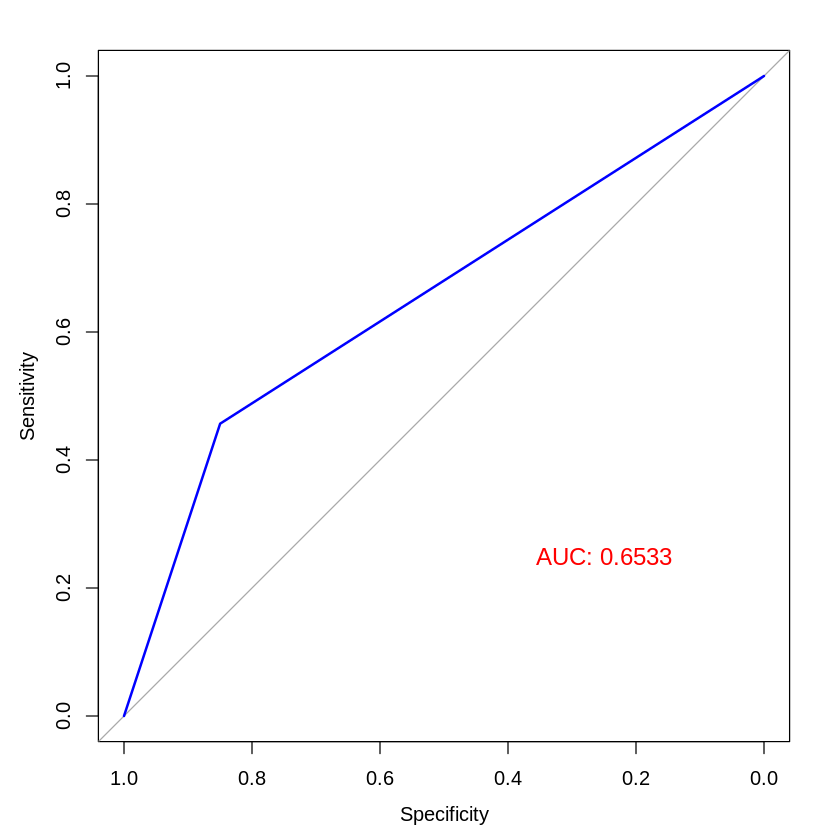

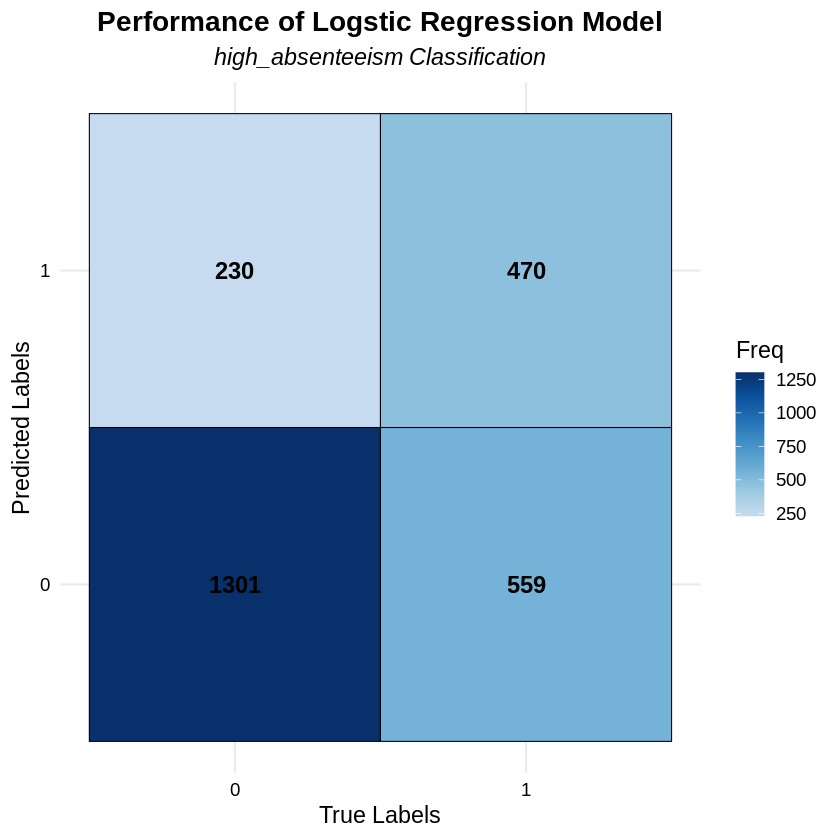

In [15]:
# Model with self-defined absenteeism threshold
df1 <- full_df |> select(-high_absenteeism_doe)
fit_log_model(df1, "high_absenteeism")

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Train Accuracy: " "0.73857421875"   
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1724  506
         1  123  207
                                          
               Accuracy : 0.7543          
                 95% CI : (0.7371, 0.7709)
    No Information Rate : 0.7215          
    P-Value [Acc > NIR] : 9.752e-05       
                                          
                  Kappa : 0.2679          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.29032         
            Specificity : 0.93341         
         Pos Pred Value : 0.62727         
         Neg Pred Value : 0.77309         
             Prevalence : 0.27852         
         Detection Rate : 0.08086         
   Detection Prevalence : 0.12891         
      Balanced Accuracy : 0.61186         
                                          
       'Positive' Class :

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Prediction Reference Freq
1          0         0 1724
2          1         0  123
3          0         1  506
4          1         1  207


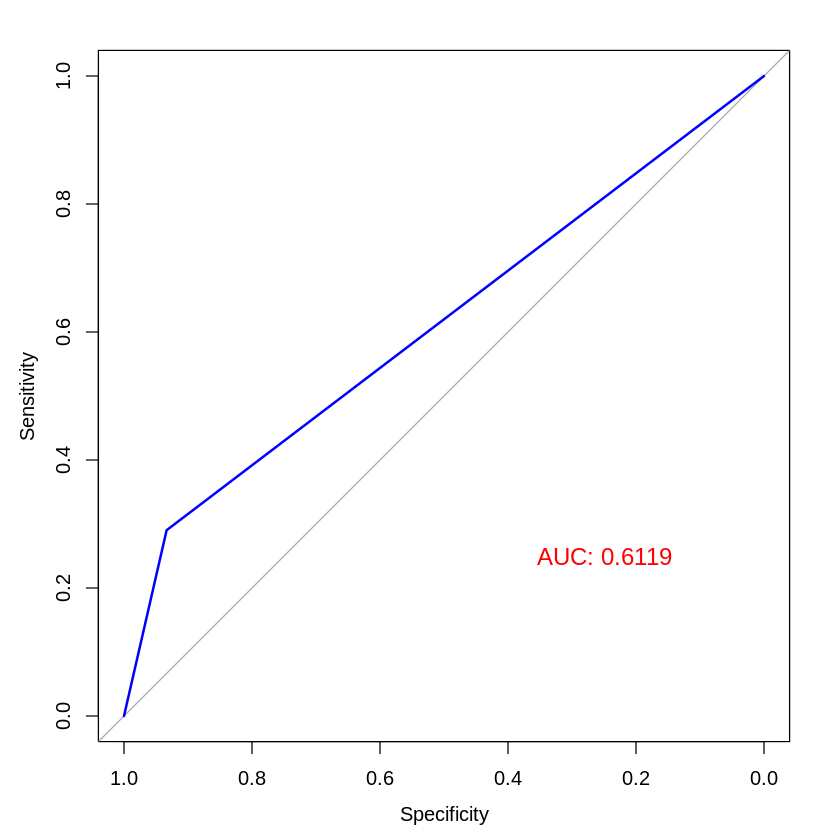

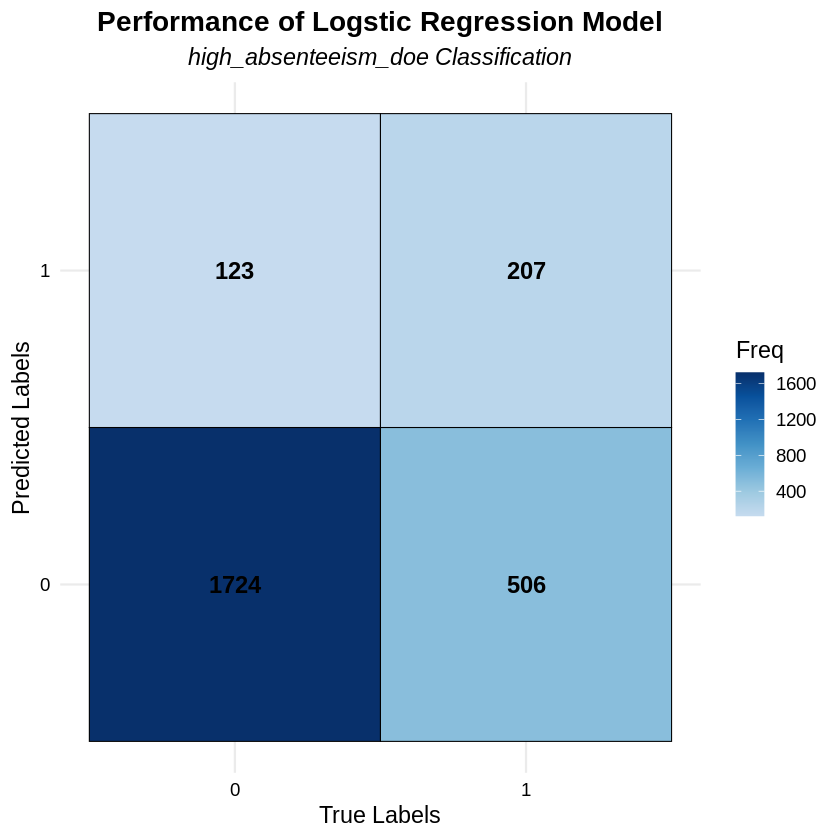

In [16]:
# Model with DOE-defined absenteeism threshold
df2 <- full_df |> select(-high_absenteeism)
fit_log_model(df2, "high_absenteeism_doe")

### Fitting on Best Subset Selection

Next, we evaluate performance using a feature set derived via best subset selection. As expected, performance is similar to using the full dataset since only a few features were removed.

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Train Accuracy: " "0.68623046875"   
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1295  560
         1  236  469
                                         
               Accuracy : 0.6891         
                 95% CI : (0.6707, 0.707)
    No Information Rate : 0.598          
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3181         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.4558         
            Specificity : 0.8459         
         Pos Pred Value : 0.6652         
         Neg Pred Value : 0.6981         
             Prevalence : 0.4020         
         Detection Rate : 0.1832         
   Detection Prevalence : 0.2754         
      Balanced Accuracy : 0.6508         
                                         
       'Positive' Class : 1              
  

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Prediction Reference Freq
1          0         0 1295
2          1         0  236
3          0         1  560
4          1         1  469


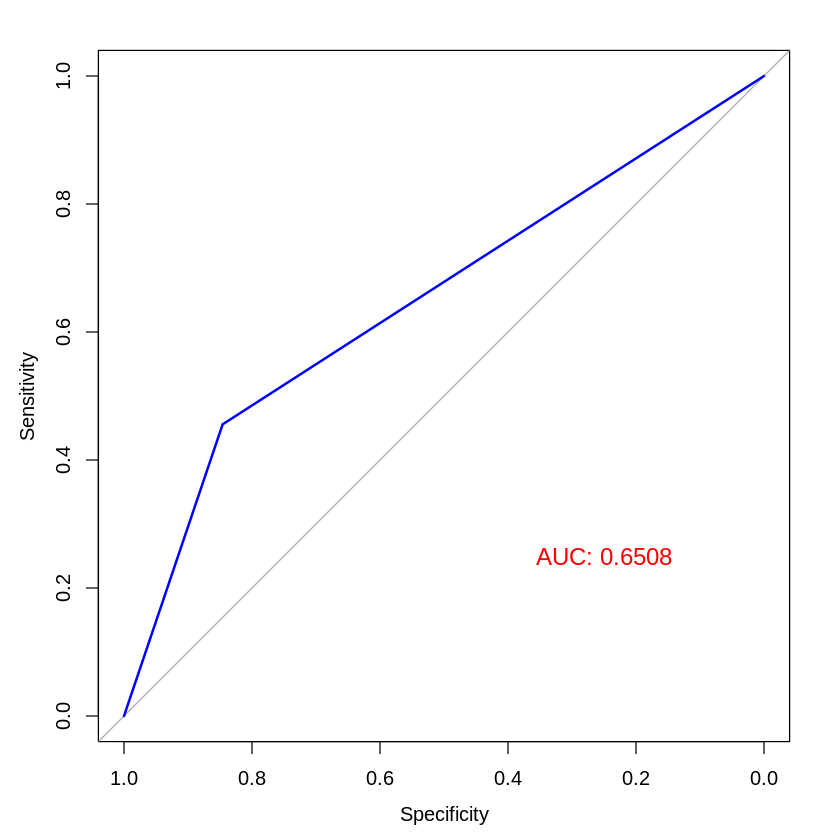

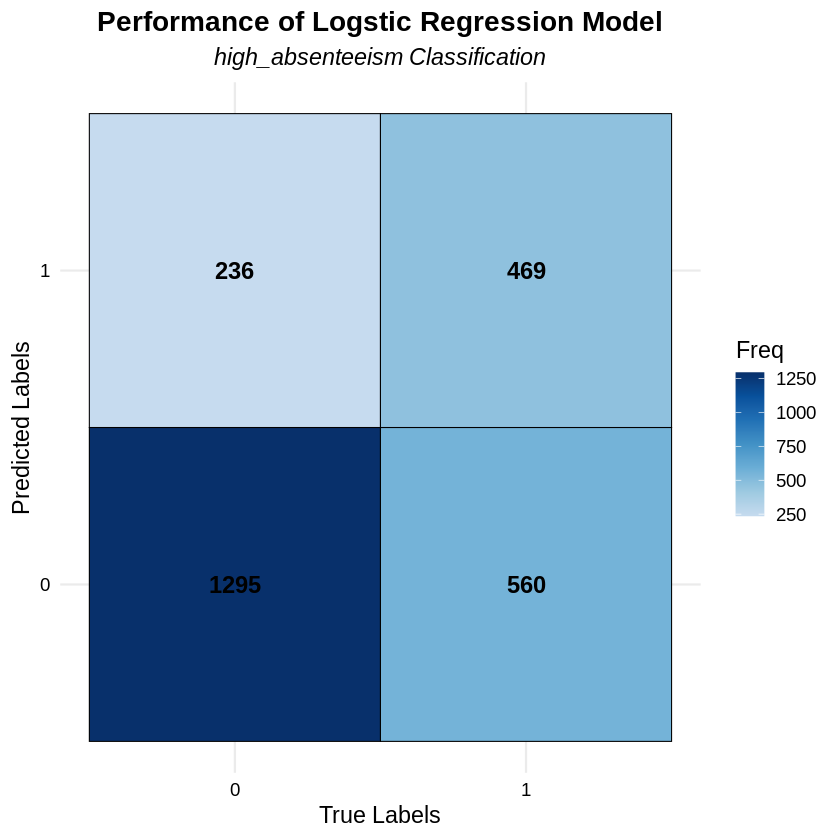

In [17]:
# Model using best subset features for self-defined absenteeism
df3 <- bss_df |> select(-high_absenteeism_doe)
fit_log_model(df3, "high_absenteeism")

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Train Accuracy: " "0.7373046875"    
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1717  504
         1  130  209
                                         
               Accuracy : 0.7523         
                 95% CI : (0.7351, 0.769)
    No Information Rate : 0.7215         
    P-Value [Acc > NIR] : 0.0002333      
                                         
                  Kappa : 0.2655         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.29313        
            Specificity : 0.92962        
         Pos Pred Value : 0.61652        
         Neg Pred Value : 0.77308        
             Prevalence : 0.27852        
         Detection Rate : 0.08164        
   Detection Prevalence : 0.13242        
      Balanced Accuracy : 0.61137        
                                         
       'Positive' Class : 1              
  

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Prediction Reference Freq
1          0         0 1717
2          1         0  130
3          0         1  504
4          1         1  209


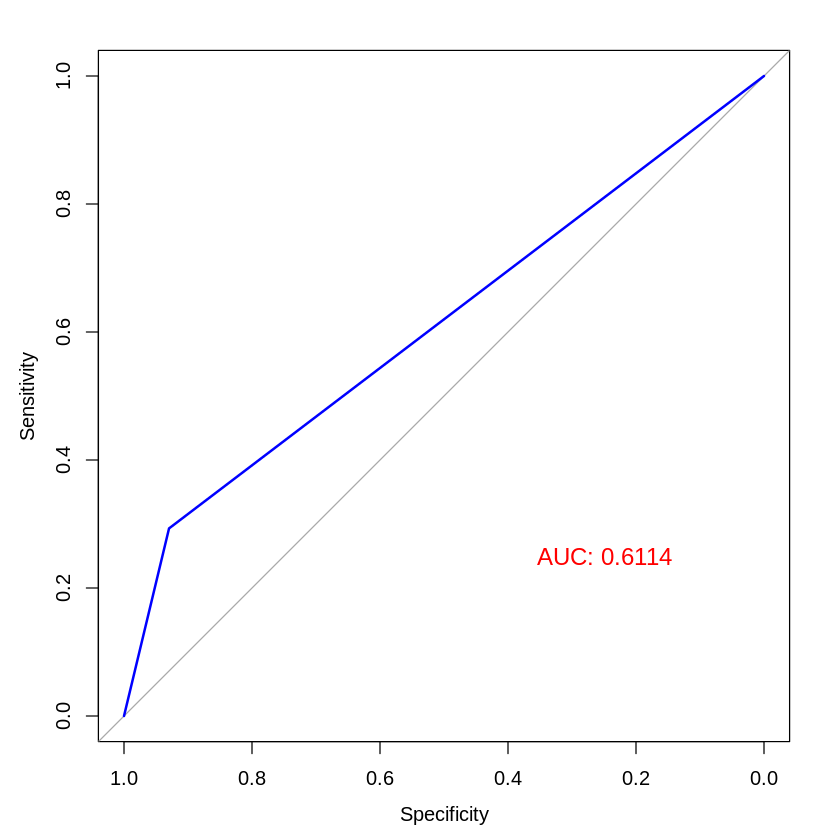

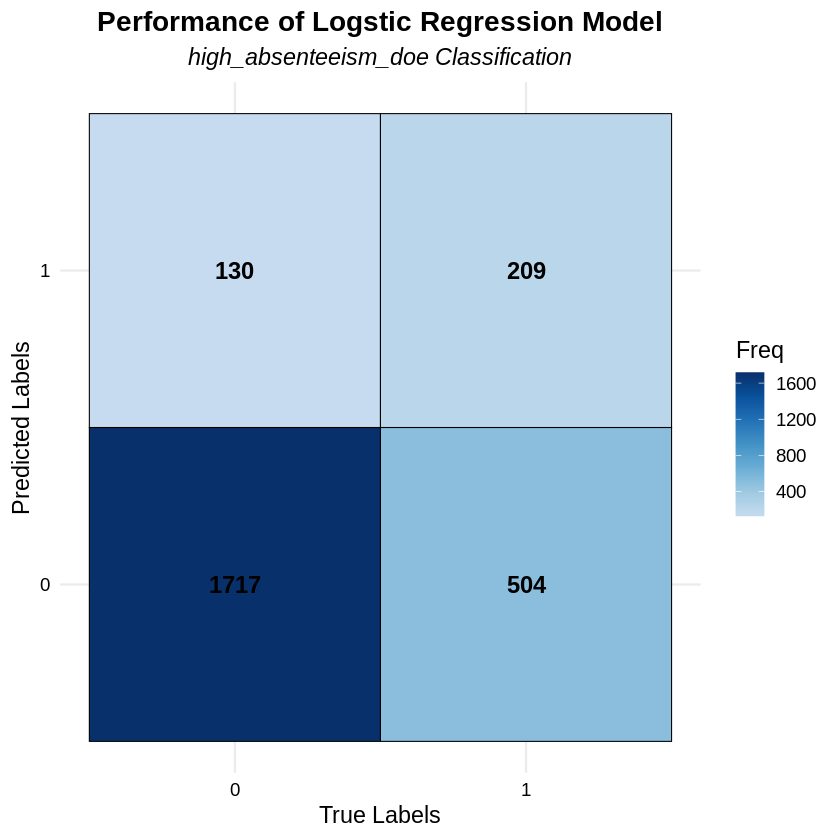

In [18]:
# Model using best subset features for DOE-defined absenteeism
df4 <- bss_df |> select(-high_absenteeism)
fit_log_model(df4, "high_absenteeism_doe")

### Transforming Data

Our EDA suggested that many numeric features are right-skewed or exponentially distributed. To address this, we apply a `log1p` transformation to all non-target variables. This transformation improves both accuracy and AUC, but model performance still indicates that logistic regression may be too simplistic to fully capture the complexity of chronic absenteeism.

[1] "Train Accuracy: " "0.72451171875"   
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1290  433
         1  241  596
                                          
               Accuracy : 0.7367          
                 95% CI : (0.7192, 0.7537)
    No Information Rate : 0.598           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4351          
                                          
 Mcnemar's Test P-Value : 1.88e-13        
                                          
            Sensitivity : 0.5792          
            Specificity : 0.8426          
         Pos Pred Value : 0.7121          
         Neg Pred Value : 0.7487          
             Prevalence : 0.4020          
         Detection Rate : 0.2328          
   Detection Prevalence : 0.3270          
      Balanced Accuracy : 0.7109          
                                          
       'Positive' Class :

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Prediction Reference Freq
1          0         0 1290
2          1         0  241
3          0         1  433
4          1         1  596


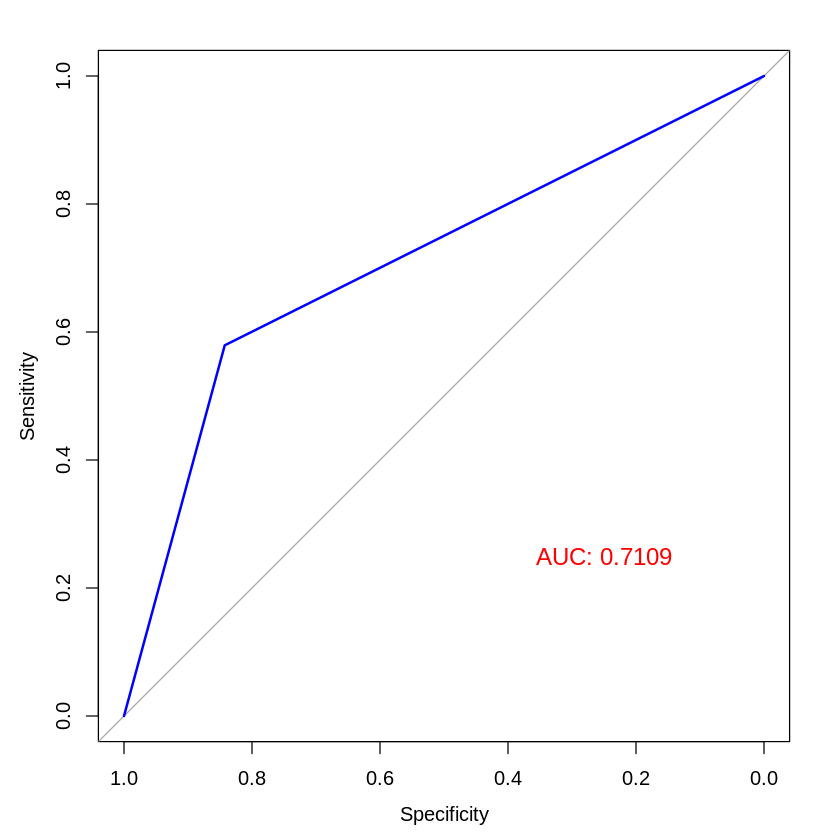

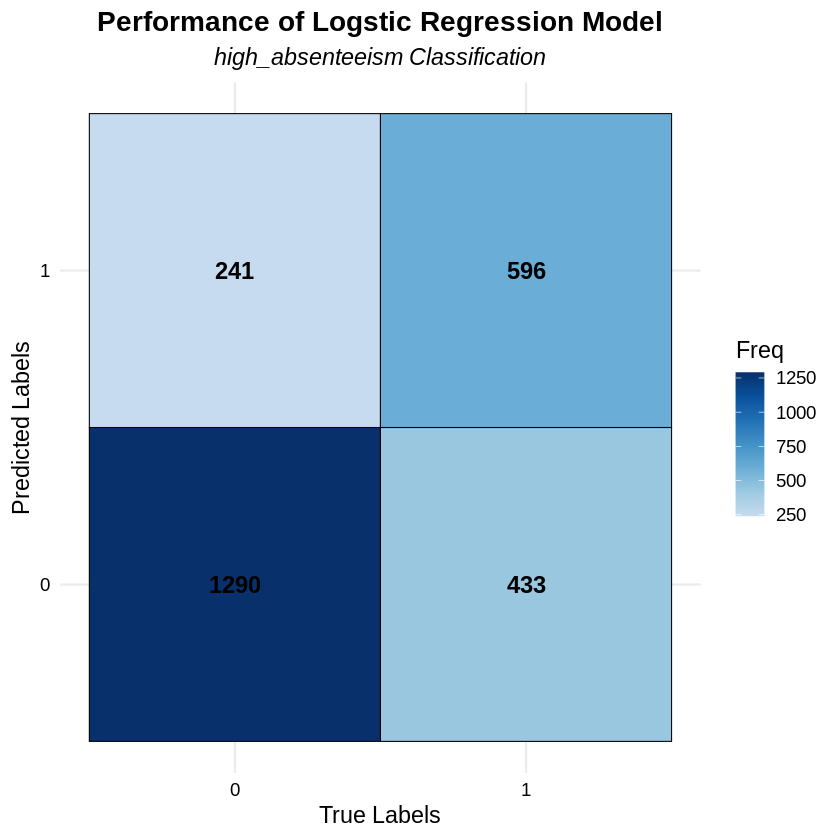

In [19]:
# Log-transform all features except target (high_absenteeism)
df5 <- full_df |>
  select(-high_absenteeism_doe) |>
  mutate(across(-c(high_absenteeism, white_pct), log1p))

fit_log_model(df5, "high_absenteeism")

[1] "Train Accuracy: " "0.758203125"     
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1709  451
         1  138  262
                                          
               Accuracy : 0.7699          
                 95% CI : (0.7531, 0.7861)
    No Information Rate : 0.7215          
    P-Value [Acc > NIR] : 1.44e-08        
                                          
                  Kappa : 0.3383          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3675          
            Specificity : 0.9253          
         Pos Pred Value : 0.6550          
         Neg Pred Value : 0.7912          
             Prevalence : 0.2785          
         Detection Rate : 0.1023          
   Detection Prevalence : 0.1562          
      Balanced Accuracy : 0.6464          
                                          
       'Positive' Class :

Setting levels: control = 0, case = 1

Setting direction: controls < cases



  Prediction Reference Freq
1          0         0 1709
2          1         0  138
3          0         1  451
4          1         1  262


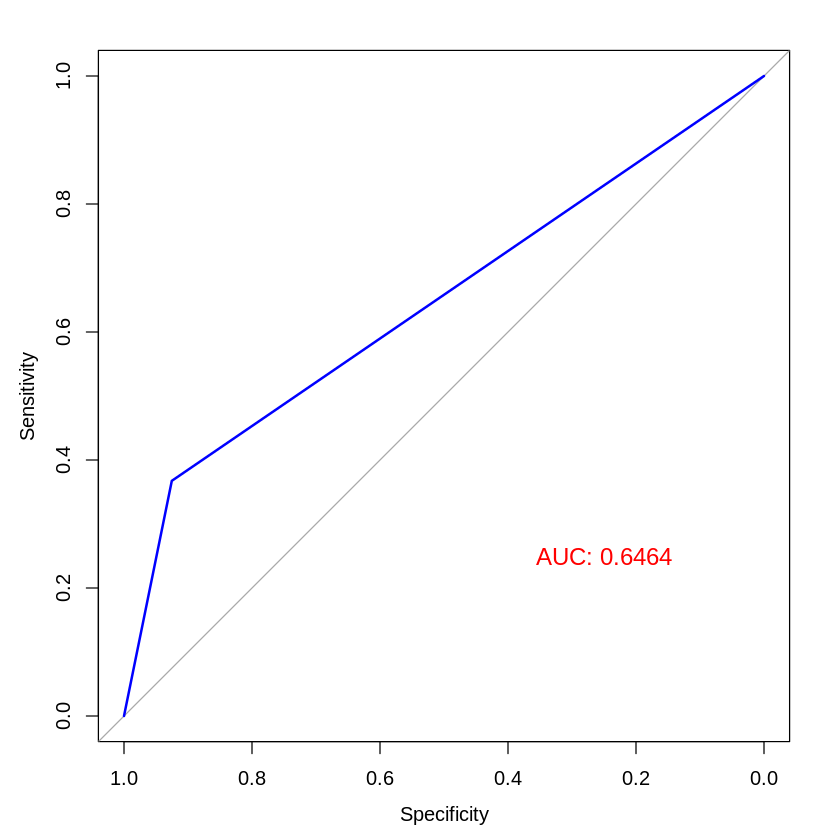

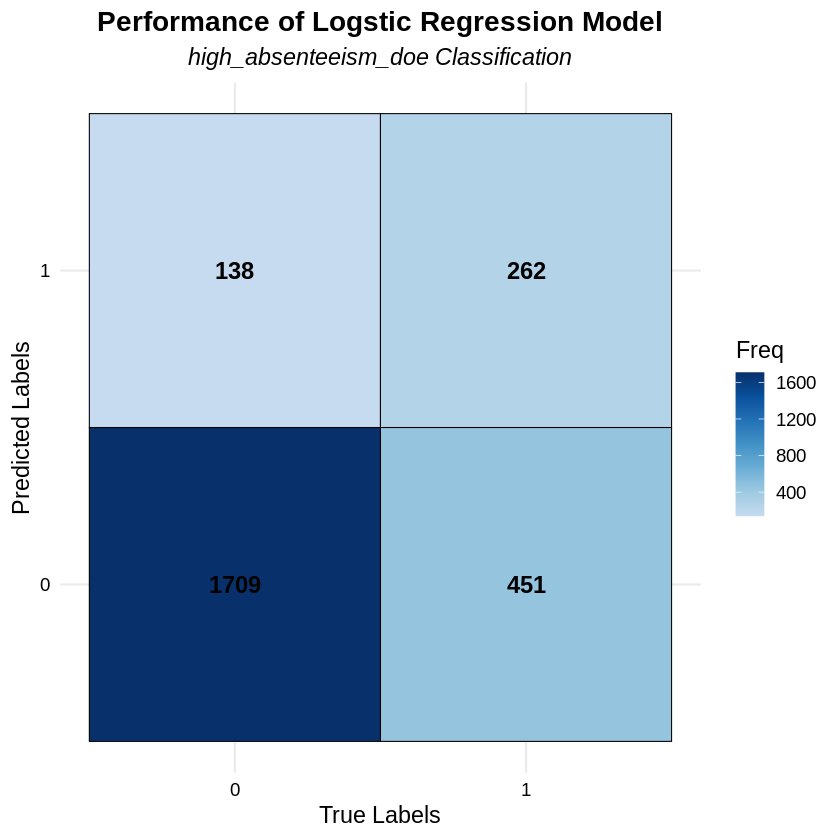

In [20]:
# Log-transform all features except target (high_absenteeism_doe)
df6 <- full_df |>
  select(-high_absenteeism) |>
  mutate(across(-high_absenteeism_doe, log1p))


fit_log_model(df6, "high_absenteeism_doe")

### Takeaways
- **Log transformation** helped improve both accuracy and AUC slightly over the raw feature models.
- There's a trade-off between precision and recall across the two target variables
  - For `high_absenteeism`, the model is more balanced.
  - For `high_absenteeism_doe`, the model favors precision and overall accuracy at the cost of recall.
- Overall, logistic regression has limitations in capturing the likely **non-linear and complex** relationships in the data, especially given the moderate AUC values and lower recall for some outcomes.